<div style="background-color:#ADD8E6">
<h3> Steps Taken </h3>
<p> 1. Extracting Data <br>
2. Defining Project Objective <br>
3. Data Description, Cleaning, and EDA <br>
4. MVP: Applying and Validating Algorithm <br>
5. Improving the Model <br>
6. Final Model <br>
7. Results </p>

In [1]:
# Libraries
import pandas as pd
import numpy as np
import glob

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

# Prediction Model
from sklearn.cluster import KMeans

# Evaluation Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import pairwise_distances_argmin_min
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer

# Parameters
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)

<div style="background-color:#ADD8E6">
<h3> 1. Extracting Data </h3>
<p> I previously treated the original survey-based data in Excel before moving over to Python. </p>

The dataset is based on in-situ surveys carried out in five counties in Northern Kenya in November 2022 organized by United Nations Office for the Coordination of Humanitarian Affairs (OCHA). In order to combine the datasets, I previously standardized in Excel the questions across the five surveys. Additionally, I deleted (majorily) empty columns, columns that don't exist across all five datasets, and columns with identical/highly similar information. I also divided columns with more than one data point per cell in the respective amount of individual cells. <br>

The original datasource: https://data.humdata.org/dataset/kenya-displacement-baseline-multi-sectoral-location-assessment-iom-dtm

In [2]:
# getting a list of all Excel file paths in the directory
excel_files = glob.glob('/Users/ingaeumann/Documents/LERNEN/DATA Sciences/IRONHACK/Final Project/displacement-and-mobility-northern-kenya/surveys/*.xlsx')

# initialising an empty list to store dataframes from each file
dataframes = []

# reading each Excel file into a dataframe and store it in the list
for file in excel_files:
    df = pd.read_excel(file, sheet_name = 1)
    # print("Column names for", file, ":", df.columns)  # Printing the column names
    dataframes.append(df)

# concatenating all dataframe in the list into a single dataframe
data = pd.concat(dataframes, ignore_index=True)

In [3]:
data.head()

,Date of Assessment,County,Sub-County,Type of Interview,Key responded Sex,Location Type,No. of Families/HHs in this sub location / Village unit,Are there absentees in the sub location/ village unit?,When did they leave the sub-location / village unit?,Number of Households,1st reason for departure,2nd reason for departure,3rd reason for departure,Are there Pastoralist drop out in the Sub location / village unit?,When did they drop the pastoral livestock production?,Number of Households 1,1st reason for dropping out,2nd reason for dropping out,3rd reason for dropping out,Are there Arrivals in the sub location/ village unit ?,When did they arrive in the sub-location / village?,Number of Households 2,Country majority arrived from (only for Kenyan National),"County from where, for majority","Sub-county from where, for majority",1st reason for departure from habitual residence,2nd reason for departure from habitual residence,3rd reason for departure from habitual residence,Are there Returnees in the sub location/village unit?,When did they arrive in the sub-location?,Number of Households 3,Country they returned from,"County they returned from, for majority",Sub-county they returned from for majority,1st reason for returning,2nd reason for returning,Where are the returnees living?,What is the first main livelihood options in your sub location?,What is the estimated no of households that depend on the first livelihood?,What is the second main livelihood options in your sub location?,What is the estimated no of households that depend on the second livelihood?,What is the third main livelihood options in your sub location?,What is the estimated no of households that depend on the third livelihood?,What are the challenges facing the sub location/ village unit in the last 1 year?,What are the challenges facing the sub location/ village unit in the last 1 year? 1,What are the challenges facing the sub location/ village unit in the last 1 year? 2,What are the Primary health concern in the sub location/ village unit?,What are the Primary health concern in the sub location/ village unit ? 1,What are the Primary health concern in the sub location/ village unit? 2,Is there a health facility in this sub location/ village unit?,"If there is a health facility, what is the main problem with the health service?",What is the structural status of the health facility?,What is the main water source for the farming and livestock rearing?,How many water sources are currently functional?,Where do most people of this settlement collect drinking water?,How long does it take to reach the nearest water source? (one-way),What is the average queue time for water?,What proportion of people in the sub location/ village unit have access water for drinking?,"What proportion of people in the sub location/village unit have access water for cooking, bathing and washing?",What problems do people face in accessing water?,Does the sub location/village unit have a water user committee (WASHCO)?,Who mainly supports the sub location/ village unit in maintaining the boreholes/taps/wells?,What problems does the community face when it comes to latrines?,What are the most common water treatment methods used,Is there an educational facility for children in this sub location/ village unit ?,Estimated number of students in the sub location/ village unit,Estimated number of school dropouts in the sub location/ village unit,What is the main safety concern with the current shelter?
0,2022-11-24 00:00:00,Marsabit,Moyale,Face-to-face interview,Male,Urban settlement or Town,1339.0,Yes,Before 2020,8.0,Ethinic Clashes,Resource-based conflict,NaN,Yes,2020 to 2022,3.0,Drought,Lack of water and pasture,NaN,Yes,Before 2020,7.0,Ethiopia,NaN,NaN,Ethinic Clashes,Resource-based conflict,Drought,Yes,NaN,2.0,Ethiopia,NaN,NaN,Wanted or needed to rejoin family,NaN,Host Community,Trade,200.0,Pastoralism,500.0,Employment (includes public and private sectors),1000.0,Environmental challenges,Safety and se

<div style="background-color:#ADD8E6">
<h3> 2. Defining Project Objective </h3>
<p> Based on the data I extracted from the web the following objective can be set. </p>

**“Analysing and Evaluating Mobility in Northern Kenya”**

The aim is to identify the key factors influencing mobility in the North of Kenya. And specifically observe the role droughts play in the region.
With a multi-feature target, the analysis is done by applying unsupervised learning.

BACKGROUND: The ASAL region of Kenya has endured three severe droughts in the last decade (2010-2011, 2016-2017 and 2020-2022). The most recent drought (2020 - 2022) has also been the most severe and longest with widespread livelihood losses and massive displacement of populations.

<div style="background-color:#ADD8E6">
<h3> 3. Data Description, Cleaning, and EDA </h3>
<p> Exploring and cleaning the data deeply is essential since my dataset is based on survey data. </p>

In [4]:
data.shape

(864, 68)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 864 entries, 0 to 863
Data columns (total 68 columns):
 #   Column                                                                                                          Non-Null Count  Dtype  
---  ------                                                                                                          --------------  -----  
 0   Date of Assessment                                                                                              862 non-null    object 
 1   County                                                                                                          862 non-null    object 
 2   Sub-County                                                                                                      862 non-null    object 
 3   Type of Interview                                                                                               862 non-null    object 
 4   Key responded Sex                           

In [6]:
data.columns = data.columns.str.strip()
data.columns = data.columns.str.replace(' ', '_')
data.columns = data.columns.str.lower()
data.columns

Index(['date_of_assessment', 'county', 'sub-county', 'type_of_interview',
       'key_responded_sex', 'location_type',
       'no._of_families/hhs_in_this_sub_location_/_village_unit',
       'are_there_absentees_in_the_sub_location/_village_unit?',
       'when_did_they_leave_the_sub-location_/_village_unit?',
       'number_of_households', '1st_reason_for_departure',
       '2nd_reason_for_departure', '3rd_reason_for_departure',
       'are_there_pastoralist_drop_out_in_the_sub_location_/_village_unit?',
       'when_did_they_drop_the_pastoral_livestock_production?',
       'number_of_households_1', '1st_reason_for_dropping_out',
       '2nd_reason_for_dropping_out', '3rd_reason_for_dropping_out',
       'are_there_arrivals_in_the_sub_location/_village_unit_?',
       'when_did_they_arrive_in_the_sub-location_/_village?',
       'number_of_households_2',
       'country_majority_arrived_from_(only_for_kenyan_national)',
       'county_from_where,_for_majority',
       'sub-county_fro

**There is a number of columns that are not important for the defined objective:** <br>
- The characteristics of the person that was interviewed, the type of interview. <br>
- The county people arrived/returned from. Information on the sub-county is sufficient and more exact to observe and evaluate mobility. <br>
- The columns answering with a Yes/No whether people left or arrived in the location is also irrelevant, since there is another column stating the number of households that left/arrived. <br>
- For the analysis it is also irrelevant whether the arrivals/returnees are living in the host community or nearby, information on movements as well as reason(s) is sufficient.
- There is a number of columns dealing with pastoralism and access to drinking water in the region. Some of them factually deliver similar information, therefore a couple of them can be dropped without interfering with achieving the objective.
- The information on health can be reduced to concerns in order to tackle the objective.

In [7]:
data = data.drop(['type_of_interview', 'key_responded_sex', 'are_there_absentees_in_the_sub_location/_village_unit?', 'are_there_pastoralist_drop_out_in_the_sub_location_/_village_unit?', 'are_there_returnees_in_the_sub_location/village_unit?', 'are_there_arrivals_in_the_sub_location/_village_unit_?', 'when_did_they_arrive_in_the_sub-location?', 'county_from_where,_for_majority', 'county_they_returned_from,_for_majority', 'where_are_the_returnees_living?', 'what_problems_do_people_face_in_accessing_water?', 'what_is_the_main_water_source_for_the_farming_and_livestock_rearing?', 'where_do_most_people_of_this_settlement_collect_drinking_water?', 'does_the_sub_location/village_unit_have_a_water_user_committee_(washco)?', 'what_are_the_most_common_water_treatment_methods_used', 'who_mainly_supports_the_sub_location/_village_unit_in_maintaining_the_boreholes/taps/wells?', 'is_there_a_health_facility_in_this_sub_location/_village_unit?', 'if_there_is_a_health_facility,_what_is_the_main_problem_with_the_health_service?', 'what_is_the_structural_status_of_the_health_facility?', 'what_problems_does_the_community_face_when_it_comes_to_latrines?'], axis=1)

In [8]:
data = data.rename(columns={
    'date_of_assessment': 'assessment_date',
    'no._of_families/hhs_in_this_sub_location_/_village_unit': 'households_in_location',
    'when_did_they_leave_the_sub-location_/_village_unit?': 'departure_date',
    'number_of_households': 'households_departed',
    'when_did_they_drop_the_pastoral_livestock_production?': 'pastoralism_drop_date',
    'number_of_households_1': 'households_pastoralism_drop',
    '1st_reason_for_dropping_out': '1st_reason_to_drop',
    '2nd_reason_for_dropping_out': '2nd_reason_to_drop',
    '3rd_reason_for_dropping_out': '3rd_reason_to_drop',
    'when_did_they_arrive_in_the_sub-location_/_village?': 'arrival_date',
    'number_of_households_2': 'households_arrived',
    'country_majority_arrived_from_(only_for_kenyan_national)': 'country_arrived_from',
    'sub-county_from_where,_for_majority': 'sub-county_arrived_from',
    '1st_reason_for_departure_from_habitual_residence': '1st_reason_for_departure_from_origin',
    '2nd_reason_for_departure_from_habitual_residence': '2nd_reason_for_departure_from_origin',
    '3rd_reason_for_departure_from_habitual_residence': '3rd_reason_for_departure_from_origin',
    'number_of_households_3': 'households_returned',
    'country_they_returned_from': 'country_returned_from',
    'sub-county_they_returned_from_for_majority': 'sub-county_returned_from',
    'what_is_the_first_main_livelihood_options_in_your_sub_location?': 'livelihood_1',
    'what_is_the_estimated_no_of_households_that_depend_on_the_first_livelihood?': 'households_livelihood_1',
    'what_is_the_second_main_livelihood_options_in_your_sub_location?': 'livelihood_2',
    'what_is_the_estimated_no_of_households_that_depend_on_the_second_livelihood?': 'households_livelihood_2',
    'what_is_the_third_main_livelihood_options_in_your_sub_location?': 'livelihood_3',
    'what_is_the_estimated_no_of_households_that_depend_on_the_third_livelihood?': 'households_livelihood_3',
    'what_are_the_challenges_facing_the_sub_location/_village_unit_in_the_last_1_year?': '1st_challenge',
    'what_are_the_challenges_facing_the_sub_location/_village_unit_in_the_last_1_year?_1': '2nd_challenge',
    'what_are_the_challenges_facing_the_sub_location/_village_unit_in_the_last_1_year?_2': '3rd_challenge',
    'what_are_the_primary_health_concern_in_the_sub_location/_village_unit?': '1st_health_concern',
    'what_are_the_primary_health_concern_in_the_sub_location/_village_unit_?_1': '2nd_health_concern',
    'what_are_the_primary_health_concern_in_the_sub_location/_village_unit?_2': '3rd_health_concern',
    'how_many_water_sources_are_currently_functional?': 'functional_watersources',
    'how_long_does_it_take_to_reach_the_nearest_water_source?_(one-way)': 'watersource_distance',
    'what_is_the_average_queue_time_for_water?': 'water_queue_time',
    'what_proportion_of_people_in_the_sub_location/_village_unit_have_access_water_for_drinking?': 'percent_drinkingwater_access',
    'what_proportion_of_people_in_the_sub_location/village_unit_have_access_water_for_cooking,_bathing_and_washing?': 'percent_cookingwater_access',
    'is_there_an_educational_facility_for_children_in_this_sub_location/_village_unit_?': 'educational_facility',
    'estimated_number_of_students_in_the_sub_location/_village_unit': 'students',
    'estimated_number_of_school_dropouts_in_the_sub_location/_village_unit': 'school_dropouts',
    'what_is_the_main_safety_concern_with_the_current_shelter?': 'safety_concerns'
})
# data.columns

In [9]:
# reordering columns for better logic
data = data[['assessment_date', 'county', 'sub-county', 'location_type', 'households_in_location', 'households_departed',
             'departure_date', '1st_reason_for_departure', '2nd_reason_for_departure','3rd_reason_for_departure', 'households_pastoralism_drop',
             'pastoralism_drop_date', '1st_reason_to_drop', '2nd_reason_to_drop', '3rd_reason_to_drop', 'households_arrived', 'arrival_date',
             'country_arrived_from', 'sub-county_arrived_from', '1st_reason_for_departure_from_origin', '2nd_reason_for_departure_from_origin',
             '3rd_reason_for_departure_from_origin', 'households_returned', 'country_returned_from', 'sub-county_returned_from', '1st_reason_for_returning', '2nd_reason_for_returning',
             'livelihood_1', 'households_livelihood_1', 'livelihood_2', 'households_livelihood_2', 'livelihood_3', 'households_livelihood_3', '1st_challenge',
             '2nd_challenge', '3rd_challenge', '1st_health_concern', '2nd_health_concern', '3rd_health_concern', 'functional_watersources', 
             'watersource_distance', 'water_queue_time', 'percent_drinkingwater_access', 'percent_cookingwater_access', 
             'educational_facility', 'students', 'school_dropouts', 'safety_concerns']]
# data.head(10)

In [10]:
data.shape

(864, 48)

In [11]:
# checking for duplicates
duplicates = data[data.duplicated(keep=False)]
duplicates

,assessment_date,county,sub-county,location_type,households_in_location,households_departed,departure_date,1st_reason_for_departure,2nd_reason_for_departure,3rd_reason_for_departure,households_pastoralism_drop,pastoralism_drop_date,1st_reason_to_drop,2nd_reason_to_drop,3rd_reason_to_drop,households_arrived,arrival_date,country_arrived_from,sub-county_arrived_from,1st_reason_for_departure_from_origin,2nd_reason_for_departure_from_origin,3rd_reason_for_departure_from_origin,households_returned,country_returned_from,sub-county_returned_from,1st_reason_for_returning,2nd_reason_for_returning,livelihood_1,households_livelihood_1,livelihood_2,households_livelihood_2,livelihood_3,households_livelihood_3,1st_challenge,2nd_challenge,3rd_challenge,1st_health_concern,2nd_health_concern,3rd_health_concern,functional_watersources,watersource_distance,water_queue_time,percent_drinkingwater_access,percent_cookingwater_access,educational_facility,students,school_dropouts,safety_concerns


In [12]:
# checking for NaNs
data.isna().sum()

assessment_date                           2
county                                    2
sub-county                                2
location_type                             2
households_in_location                    2
households_departed                     109
departure_date                          153
1st_reason_for_departure                153
2nd_reason_for_departure                370
3rd_reason_for_departure                538
households_pastoralism_drop              36
pastoralism_drop_date                    55
1st_reason_to_drop                       55
2nd_reason_to_drop                      141
3rd_reason_to_drop                      302
households_arrived                      100
arrival_date                            190
country_arrived_from                    189
sub-county_arrived_from                 233
1st_reason_for_departure_from_origin    190
2nd_reason_for_departure_from_origin    413
3rd_reason_for_departure_from_origin    541
households_returned             

First, I deal with the date column and unify format.

In [13]:
data.dropna(subset=['assessment_date'], inplace=True)

In [14]:
data['assessment_date'].unique()

array([Timestamp('2022-11-24 00:00:00'), Timestamp('2022-11-26 00:00:00'),
       Timestamp('2022-11-23 00:00:00'), Timestamp('2022-11-22 00:00:00'),
       Timestamp('2022-11-21 00:00:00'), Timestamp('2022-11-25 00:00:00'),
       Timestamp('2022-11-28 00:00:00'), Timestamp('2022-11-27 00:00:00'),
       Timestamp('2022-11-29 00:00:00'), Timestamp('2022-12-01 00:00:00'),
       Timestamp('2022-11-30 00:00:00'), '2023-01-16', '2023-01-17',
       '2023-01-18', '2023-01-19', '2023-01-20', '2023-01-21',
       '2023-01-22', '2023-01-23', '2023-01-24', '2023-01-25',
       '2023-01-26', '2023-01-27', '2023-01-28',
       Timestamp('2022-10-26 00:00:00'), Timestamp('2022-10-27 00:00:00'),
       Timestamp('2022-10-28 00:00:00'), Timestamp('2022-10-29 00:00:00'),
       Timestamp('2022-10-30 00:00:00'), Timestamp('2022-10-24 00:00:00'),
       Timestamp('2022-10-31 00:00:00'), Timestamp('2022-11-01 00:00:00'),
       Timestamp('2022-11-02 00:00:00'), Timestamp('2022-11-13 00:00:00'),
      

In [15]:
# turning all rows into timestamp format
data['assessment_date'] = pd.to_datetime(data['assessment_date'])
# extracting only the date from each timestamp
data['assessment_date'] = data['assessment_date'].dt.date

Since I want to analyse the key mobility drivers in the region and the dataset is restricted to the North of Kenya, NaNs in location-related features don't concern me, I replace them with 'Other'. Missing values in arrival, departure, or pastoralism drop date concern me more (indicating whether before or as a consequence of the intense drought from 2020-2022). Having in mind that here NaNs simply indicate no departures/pastoralism drop/arrival/return, I will replace those NaNs in all related features with '0'. There is a couple additional rows that are missing data related to the movement features, here I will impute the mode to replace the NaNs. <br>

Most relevant are high amount of NaNs in features related to motivational and circumstancial factors such as reasons to move, challenges, health concerns, water access, etc. Missing reasons I will replace proportionally by existing categories of the same column to not change the distribution of the data. <br>

Problem is that even though survey questions were identical, in one of the counties (Garissa with 356 entries) only about 50% of them were asked/answered by the questionees. I do not want to loose these entries to have a complete picture of the region and to not reduce the dataset too much avoiding overfitting. Also to deal with the missing data from the survey carried out in Garissa county I will use proportional assignation. They can be predicted reasonably well by the data from other counties since the 5 counties face highly similar challenges.

In [16]:
# data.isna().sum()

In [17]:
# replacing empty values in location related columns with 'Other'
columns_to_fill = ['country_arrived_from', 'sub-county_arrived_from',
                   'country_returned_from', 'sub-county_returned_from']

for column in columns_to_fill:
    data[column].fillna('Other', inplace=True)

In [18]:
# filling NaNs in dates of departure etc. with '0' if there were no households departing etc.
data.loc[data['households_departed'].isna(), ['departure_date', '1st_reason_for_departure', '2nd_reason_for_departure', '3rd_reason_for_departure']] = '0'
data['households_departed'].fillna(0, inplace=True)
data.loc[data['households_pastoralism_drop'].isna(), ['pastoralism_drop_date', '1st_reason_to_drop', '2nd_reason_to_drop', '3rd_reason_to_drop']] = '0'
data['households_pastoralism_drop'].fillna(0, inplace=True)
data.loc[data['households_arrived'].isna(), ['arrival_date', 'country_arrived_from', 'sub-county_arrived_from', '1st_reason_for_departure_from_origin', '2nd_reason_for_departure_from_origin', '3rd_reason_for_departure_from_origin']] = '0'
data['households_arrived'].fillna(0, inplace=True)
data.loc[data['households_returned'].isna(), ['country_returned_from', 'sub-county_returned_from', '1st_reason_for_returning', '2nd_reason_for_returning']] = '0'
data['households_returned'].fillna(0, inplace=True)

In [19]:
data['departure_date'].unique()

array(['Before 2020', '2020 to 2022', nan, '0', 'Before_2020',
       '2020_to_2022'], dtype=object)

In [20]:
data['pastoralism_drop_date'].unique()

array(['2020 to 2022', 'Before 2020', nan, '2020_to_2022', 'Before_2020',
       '0'], dtype=object)

In [21]:
data['arrival_date'].unique()

array(['Before 2020', '2020 to 2022', nan, 'Before_2020', '2020_to_2022',
       '0'], dtype=object)

In [22]:
# filling the remaining NaNs with the mode
data['departure_date'].fillna(data['departure_date'].mode()[0], inplace=True)
data['departure_date'] = data['departure_date'].replace({'Before_2020': 'Before 2020', '2020_to_2022': '2020 to 2022'})
data['pastoralism_drop_date'].fillna(data['pastoralism_drop_date'].mode()[0], inplace=True)
data['pastoralism_drop_date'] = data['pastoralism_drop_date'].replace({'Before_2020': 'Before 2020', '2020_to_2022': '2020 to 2022'})
data['arrival_date'].fillna(data['arrival_date'].mode()[0], inplace=True)
data['arrival_date'] = data['arrival_date'].replace({'Before_2020': 'Before 2020', '2020_to_2022': '2020 to 2022'})
data['arrival_date'].unique()

array(['Before 2020', '2020 to 2022', '0'], dtype=object)

In [23]:
data['3rd_reason_to_drop'].value_counts()

Other                              192
Banditry                           100
Lack of water and pasture           95
Resource-based_conflict             52
Animal Disease                      37
Flash_floods_or_seasonal_floods     35
0                                   34
Drought                             27
Lack_of_water_and_pasture           14
Animal_Disease                       5
Fires                                5
Name: 3rd_reason_to_drop, dtype: int64

In [24]:
# turning 'Other' and '0' in NaNs, then taking a random sample of non-NaN values of size equal to number of NaNs and assign them randomly to fill the NaNs
def fillna_with_proportional_random(df, column):
    df[column].replace(['Other', '0'], np.nan, inplace=True) # replace 'Other' and '0' with NaNs
    random_sample = df[column].dropna().sample(df[column].isnull().sum(), replace=True)
    random_sample.index = df[df[column].isnull()].index # resetting index
    df.loc[df[column].isnull(), column] = random_sample

columns_to_fill = [
    '1st_reason_for_departure', '2nd_reason_for_departure', '3rd_reason_for_departure', 
    '1st_reason_to_drop', '2nd_reason_to_drop', '3rd_reason_to_drop',
    '1st_reason_for_departure_from_origin', '2nd_reason_for_departure_from_origin', '3rd_reason_for_departure_from_origin',
    '1st_reason_for_returning', '2nd_reason_for_returning'
]

for column in columns_to_fill:
    fillna_with_proportional_random(data, column)

In [25]:
data['3rd_reason_to_drop'].value_counts()

Lack of water and pasture          231
Banditry                           226
Resource-based_conflict            130
Animal Disease                      86
Flash_floods_or_seasonal_floods     76
Drought                             62
Lack_of_water_and_pasture           30
Animal_Disease                      11
Fires                               10
Name: 3rd_reason_to_drop, dtype: int64

Now, I am checking categories in all of the categorical columns for unification and before applying any imputation method to fill NaNs.

In [26]:
data['county'].unique()
# data['sub-county'].unique()
# data['location_type'].unique()
# data['1st_reason_for_departure'].unique()
# data['2nd_reason_for_departure'].unique()
# data['3rd_reason_for_departure'].unique()
# data['1st_reason_to_drop'].unique()
# data['2nd_reason_to_drop'].unique()
# data['3rd_reason_to_drop'].unique()
# data['country_arrived_from'].unique()
# data['sub-county_arrived_from'].unique()
# data['1st_reason_for_departure_from_origin'].unique()
# data['2nd_reason_for_departure_from_origin'].unique()
# data['3rd_reason_for_departure_from_origin'].unique()
# data['country_returned_from'].unique()
# data['sub-county_returned_from'].unique()# data['1st_reason_for_returning'].unique()
# data['2nd_reason_for_returning'].unique()
# data['livelihood_1'].unique()
# data['livelihood_2'].unique()
# data['livelihood_3'].unique()
# data['1st_challenge'].unique()
# data['2nd_challenge'].unique()
# data['3rd_challenge'].unique()
# data['1st_health_concern'].unique()
# data['2nd_health_concern'].unique()
# data['3rd_health_concern'].unique()
# data['watersource_distance'].unique()
# data['water_queue_time'].unique()
# data['percent_drinkingwater_access'].unique()
# data['percent_cookingwater_access'].unique()
# data['educational_facility'].unique()
# data['safety_concerns'].unique() 

array(['Marsabit', 'Samburu', 'Isiolo', 'Turkana', 'Garissa'],
      dtype=object)

Almost all the categorical columns have misspelling, differing spelling and unclear categories. I unify.

In [27]:
def clean_category(cat):
    if isinstance(cat, str):
        if cat in ['0', 'Ethinic Clashes', 'Ethinic_Clashes']:
            if cat == '0':
                return 'Other'
            else:
                return 'Ethnic Clashes'
        else:
            return cat.replace('_', ' ').title()
    else:
        return cat  # returning NaN as is

categorical_columns = data.select_dtypes(include=['object']).columns

for column in categorical_columns:
    data[column] = data[column].map(clean_category)

The categories of categorical columns are unified now. I proceed with imputation.

In [28]:
# data.isna().sum()

In [29]:
# separating Garissa and other county data
data_garissa = data[data['county'] == 'Garissa']
data_non_garissa = data[data['county'] != 'Garissa']

# filtering rows with NaNs in Garissa county data
data_garissa_nan = data_garissa[data_garissa.isna().any(axis=1)]

# for each row with NaN in the Garissa dataset, finding a similar row in the non-Garissa dataset and use it to fill NaNs.
for i in data_garissa_nan.index:
    similarities = data_non_garissa.apply(lambda row: (row == data_garissa_nan.loc[i]).mean(), axis=1)
    most_similar_index = similarities.idxmax()
    data_garissa_nan.loc[i] = data_garissa_nan.loc[i].fillna(data_non_garissa.loc[most_similar_index])

# concatenating the imputed and non-imputed Garissa data
data_garissa_filled = pd.concat([data_garissa_nan, data_garissa.dropna()], axis=0)

In [30]:
# concatenating the two datasets
data_cleaned = pd.concat([data_garissa_filled, data_non_garissa])

I change a couple of categorical columns to numerical since their content is of numerical nature only expressed in words.

In [31]:
# writing a dictionary for the value replacement
watersource_distance_dict = {
    '21-30 Minute Walk': 25.5,
    '31-45 Minute Walk': 38,
    'More Than 45-Minute Walk': 50,
    'Less Than 20-Minute Walk': 10,
    np.nan: np.nan
}

water_queue_time_dict = {
    'Less Than 20-Minute': 10,
    '21-30 Minute': 25.5,
    'More Than 45-Minute': 50,
    '31-45 Minute': 38,
    np.nan: np.nan
}

percentage_dict = {
    'About Half Around 50Pc': 50,
    'A Few Around 25Pc': 25,
    'Most Around 75Pc': 75,
    'Everyone Around 100Pc': 100,
    'Nobody Around 0Pc': 0,
    'Dont Know': np.nan,
    np.nan: np.nan
}

# replacing the values in the columns
data_cleaned['watersource_distance'] = data_cleaned['watersource_distance'].map(watersource_distance_dict)
data_cleaned['water_queue_time'] = data_cleaned['water_queue_time'].map(water_queue_time_dict)
data_cleaned['percent_drinkingwater_access'] = data_cleaned['percent_drinkingwater_access'].map(percentage_dict)
data_cleaned['percent_cookingwater_access'] = data_cleaned['percent_cookingwater_access'].map(percentage_dict)

Now I look at the numerical columns. I turn float into int, since there are no half households, students, watersources...

In [32]:
numerical_columns = data_cleaned.select_dtypes(include=['float64', 'int64']).columns

for col in numerical_columns:
    # handeling missing values
    data_cleaned[col] = data_cleaned[col].fillna(0)
    # rounding to the nearest integer
    data_cleaned[col] = data_cleaned[col].round()
    # converting to integer
    data_cleaned[col] = data_cleaned[col].astype(int)

There are now a couple of NaNs remaining since some interviewees did not voice a second or third concern on challenges or health. I turn these NaNs into 'No Additional Challenge'. 

In [33]:
columns_to_fill = ['2nd_challenge', '3rd_challenge', '2nd_health_concern', '3rd_health_concern']

for column in columns_to_fill:
    data_cleaned[column] = data_cleaned[column].fillna('No Additional Challenge')

In [34]:
data_cleaned.isna().sum()

assessment_date                         0
county                                  0
sub-county                              0
location_type                           0
households_in_location                  0
households_departed                     0
departure_date                          0
1st_reason_for_departure                0
2nd_reason_for_departure                0
3rd_reason_for_departure                0
households_pastoralism_drop             0
pastoralism_drop_date                   0
1st_reason_to_drop                      0
2nd_reason_to_drop                      0
3rd_reason_to_drop                      0
households_arrived                      0
arrival_date                            0
country_arrived_from                    0
sub-county_arrived_from                 0
1st_reason_for_departure_from_origin    0
2nd_reason_for_departure_from_origin    0
3rd_reason_for_departure_from_origin    0
households_returned                     0
country_returned_from             

In [35]:
# dropping the last NaN row remaining
data_cleaned.dropna(inplace=True)

In [36]:
data_cleaned.shape

(861, 48)

In [37]:
data_cleaned.head()

,assessment_date,county,sub-county,location_type,households_in_location,households_departed,departure_date,1st_reason_for_departure,2nd_reason_for_departure,3rd_reason_for_departure,households_pastoralism_drop,pastoralism_drop_date,1st_reason_to_drop,2nd_reason_to_drop,3rd_reason_to_drop,households_arrived,arrival_date,country_arrived_from,sub-county_arrived_from,1st_reason_for_departure_from_origin,2nd_reason_for_departure_from_origin,3rd_reason_for_departure_from_origin,households_returned,country_returned_from,sub-county_returned_from,1st_reason_for_returning,2nd_reason_for_returning,livelihood_1,households_livelihood_1,livelihood_2,households_livelihood_2,livelihood_3,households_livelihood_3,1st_challenge,2nd_challenge,3rd_challenge,1st_health_concern,2nd_health_concern,3rd_health_concern,functional_watersources,watersource_distance,water_queue_time,percent_drinkingwater_access,percent_cookingwater_access,educational_facility,students,school_dropouts,safety_concerns
508,2022-09-12,Garissa,Balambala,Village,230,25,2020 To 2022,Drought,Resource-Based Conflict,Resource-Based Conflict,90,2020 To 2022,Drought,Resource-Based Conflict,Banditry,15,2020 To 2022,Kenya,Lagdera,Drought,Resource-Based Conflict,Resource-Based Conflict,10,Kenya,Lagdera,Drought,Resource-Based Conflict,Agro Pastoralism,229,Farming,229,Employment (Includes Public And Private Sectors),40,Environmental Challenges,Lack Of Food And Water,No Additional Challenge,Pneumonia,No Additional Challenge,No Additional Challenge,2,50,26,25,25,Yes,1200,200,Weather
509,2022-09-13,Garissa,Balambala,Village,35,31,2020 To 2022,Drought,Resource-Based Conflict,Flash Floods Or Seasonal Floods,27,2020 To 2022,Drought,Resource-Based Conflict,Banditry,40,2020 To 2022,Kenya,Lagdera,Drought,Resource-Based Conflict,Flash Floods Or Seasonal Floods,15,Kenya,Lagdera,Drought,Resource-Based Conflict,Pastoralism,2000,Farming,20,Trade,1000,Safety And Security,Ethnic Conflicts,Lack Of Food And Water,Malaria,Pneumonia,Injury,3,38,26,50,25,Yes,1001,230,Lack Of Security
510,2022-09-12,Garissa,Ijara,Village,400,10,2020 To 2022,Drought,Resource-Based Conflict,Ethnic Clashes,1000,2020 To 2022,Drought,Resource-Based Conflict,Resource-Based Conflict,190,2020 To 2022,Kenya,Lamu/West,Drought,Resource-Based Conflict,Ethnic Clashes,500,Kenya,Lamu/West,Drought,Wanted Or Needed To Rejoin Family,Pastoralism,1200,Trade,60,Agro Pastoralism,50,Safety And Security,No Additional Challenge,No Additional Challenge,Malaria,Pneumonia,Diarrhea,3,50,50,75,75,Yes,50,20,Weather
511,2022-09-16,Garissa,Fafi,Village,200,30,2020 To 2022,Drought,Resource-Based Conflict,Flash Floods Or Seasonal Floods,30,2020 To 2022,Drought,Resource-Based Conflict,Flash Floods Or Seasonal Floods,50,2020 To 2022,Kenya,Lagdera,Drought,Resource-Based Conflict,Flash Floods Or Seasonal Floods,40,Kenya,Fafi,Drought,Resource-Based Conflict,Pastoralism,500,Agro Pastoralism,100,Trade,70,Loss Of Livelihood,Environmental Challenges,No Additional Challenge,Malaria,Typhoid,Pneumonia,2,38,26,25,50,Yes,1600,30,Lack Of Privacy
512,2022-09-16,Garissa,Fafi,Village,200,100,2020 To 2022,Drought,Resource-Based Conflict,Flash Floods Or Seasonal Floods,50,2020 To 2022,Drought,Resource-Based Conflict,Flash Floods Or Seasonal Floods,50,2020 To 2022,Kenya,Fafi,Drought,Resource-Based Conflict,Flash Floods Or Seasonal Floods,50,Kenya,Fafi,Drought,Resource-Based Conflict,Other,2000,Trade,20,Pastoralism,200,Environmental Challenges,Lack Of Food And Water,Loss Of Livelihood,Tuberculosis,Pneumonia,Malaria,0,50,50,25,25,Yes,250,70,Lack Of Basic Services Water Electricity Etc


In [38]:
data_cleaned.to_csv('data_cleaned.csv')

<div style="background-color:#ADD8E6">
<h3> 4. Applying and Validating the Algorithm </h3>
<p> For comparison, I apply clustering without and with previously scaling the features. For both datasets I try number of clusters between 2 and 9. </p>

In [39]:
# selecting the columns that most likely are drivers for mobility in the region

# categorical columns to convert
cat_cols = [
    '1st_reason_for_departure', '2nd_reason_for_departure', '3rd_reason_for_departure', 
    '1st_reason_to_drop', '2nd_reason_to_drop', '3rd_reason_to_drop', 
    '1st_reason_for_departure_from_origin', '2nd_reason_for_departure_from_origin', 
    '3rd_reason_for_departure_from_origin',
    '1st_reason_for_returning', '2nd_reason_for_returning',
    '1st_challenge', '2nd_challenge', '3rd_challenge',
    '1st_health_concern', '2nd_health_concern', '3rd_health_concern', 
    'safety_concerns', 'educational_facility'
]

# numerical columns
num_cols = ['functional_watersources', 'watersource_distance', 'water_queue_time', 
            'percent_drinkingwater_access', 'percent_cookingwater_access']

# creating a dictionary to store the encoders & applying Label Encoder to categorical columns
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    data_cleaned[col] = le.fit_transform(data_cleaned[col])
    encoders[col] = le

# concatenating categorical and numerical features
drivers = pd.concat([data_cleaned[cat_cols], data_cleaned[num_cols]], axis=1)

# scaling the data for better performance of the model
scaler = StandardScaler()
drivers_scaled = scaler.fit_transform(drivers)

# running KMeans
kmeans = KMeans(n_clusters=4, random_state=42).fit(drivers_scaled)
clusters = kmeans.predict(drivers_scaled)

In [40]:
# data = not scaled, k = 4, plot 2d

#kmeans = KMeans(n_clusters=5, random_state=42).fit(drivers)
#clusters = kmeans.predict(drivers)

#labels = np.unique(clusters)

#colors = cm.rainbow(np.linspace(0, 1, len(labels)))

#for i, color in zip(labels, colors):
    #plt.scatter(drivers[clusters == i , 0], 
                #drivers[clusters == i , 1], 
                #color=color,
                #label=i)
    
#plt.legend()
#plt.show()

Clustering and displaying the non-scaled data is impossible.

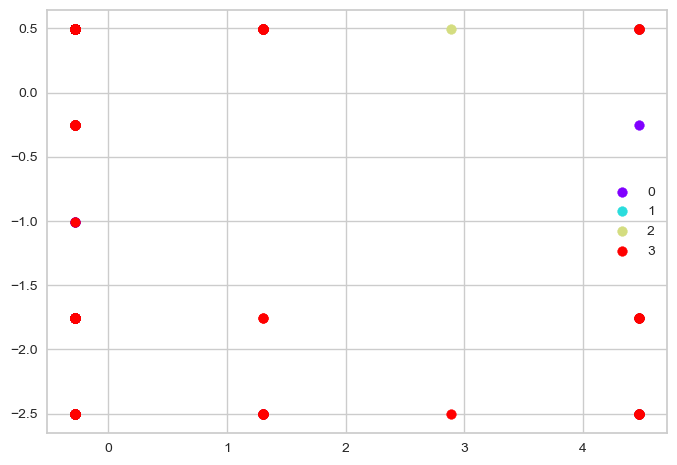

In [41]:
# data = scaled, k = 4, plot = 2d 

labels = np.unique(clusters)

colors = cm.rainbow(np.linspace(0, 1, len(labels)))

for i, color in zip(labels, colors):
    plt.scatter(drivers_scaled[clusters == i , 0], 
                drivers_scaled[clusters == i , 1], 
                color=color,
                label=i)
    
plt.legend()
plt.show()

Clustering and displying the scaled data does not look good (see above). Most likely due to the large amount of features I selected. I apply PCA to reduce the features. 

<div style="background-color:#ADD8E6">
<h3> 5. Improving the Model </h3>
<p> I want to achieve well separated clusters. </p>

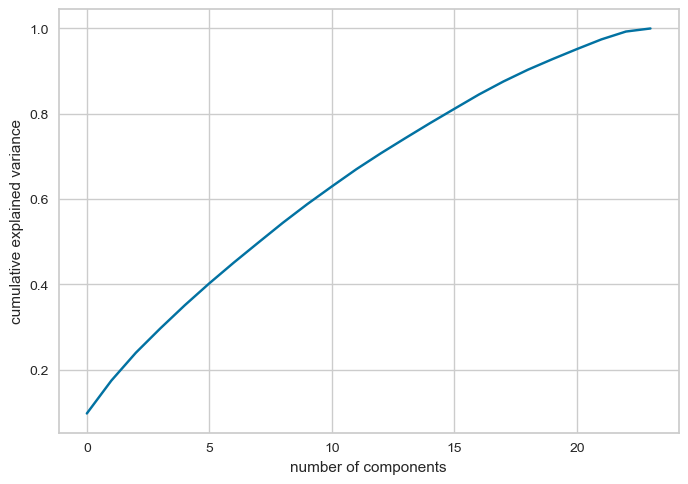

In [42]:
# checking the variance ratio to find the best number of PCA 
pca = PCA().fit(drivers_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

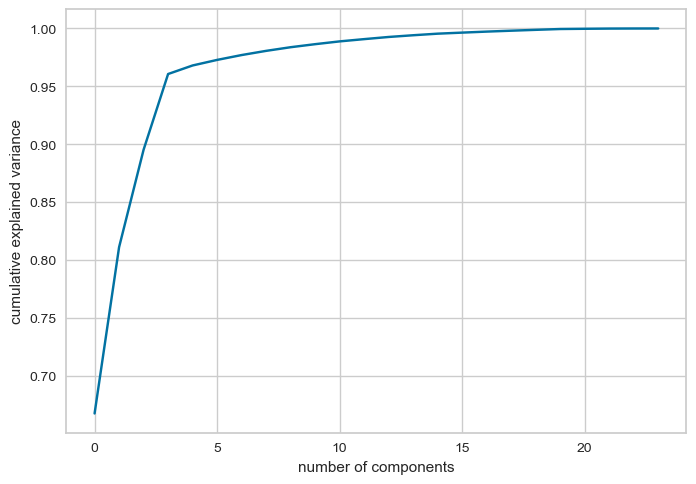

In [43]:
pca = PCA().fit(drivers)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

For the scaled data the PCA variance ratio does not provide any specific number of components to be applied. For the unscaled data and any number of clusters between 2 and 9 the best number of PCAs is 3. Hence I chose 3 also for the scaled data.

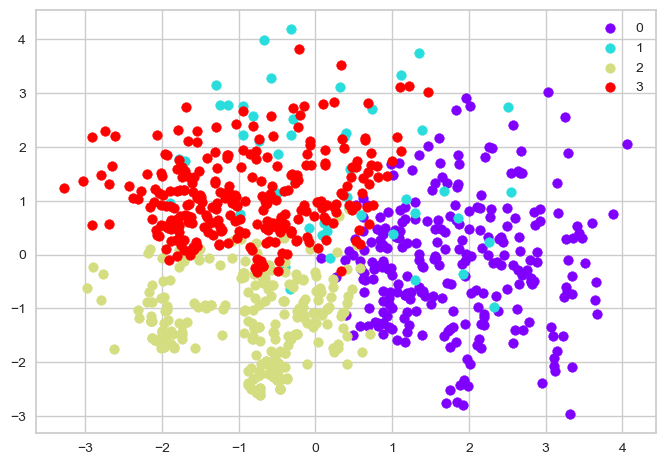

In [44]:
# data = scaled, k = 4, PCA-components = 3, plot = 2d 

pca = PCA(n_components=3)
reduced_drivers = pca.fit_transform(drivers_scaled)

labels = np.unique(clusters)

colors = cm.rainbow(np.linspace(0, 1, len(labels)))

for i, color in zip(labels, colors):
    plt.scatter(reduced_drivers[clusters == i , 0], 
                reduced_drivers[clusters == i , 1], 
                color=color,
                label=i)
    
plt.legend()
plt.show()

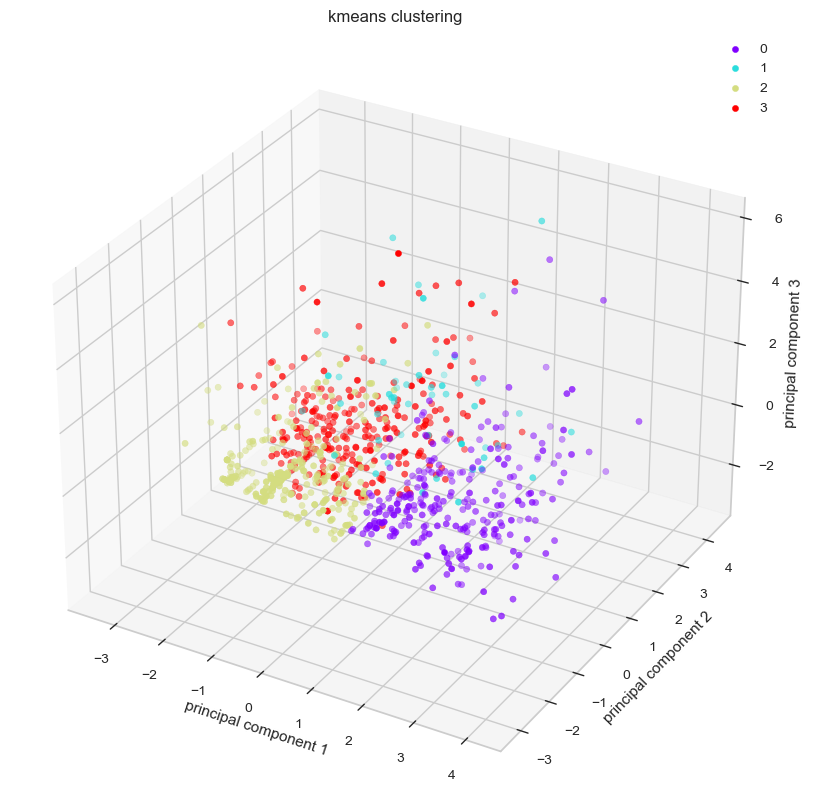

In [45]:
# data = scaled, k = 4, PCA-components = 3, plot = 3d 

pca = PCA(n_components=3)
reduced_drivers = pca.fit_transform(drivers_scaled)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

labels = np.unique(clusters)

# create a color map with enough colors
colors = cm.rainbow(np.linspace(0, 1, len(labels)))

for i, color in zip(labels, colors):
    ax.scatter(reduced_drivers[clusters == i , 0], 
               reduced_drivers[clusters == i , 1], 
               reduced_drivers[clusters == i , 2], 
               color=color,
               label = i)
    
plt.legend()
ax.set_title('kmeans clustering')
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
ax.set_zlabel('principal component 3')
plt.show()

Based on the scatter plots after PCA, clusters = 4 or 5 appear to be the best. Let's confirm with the Silhouette Visualizer.

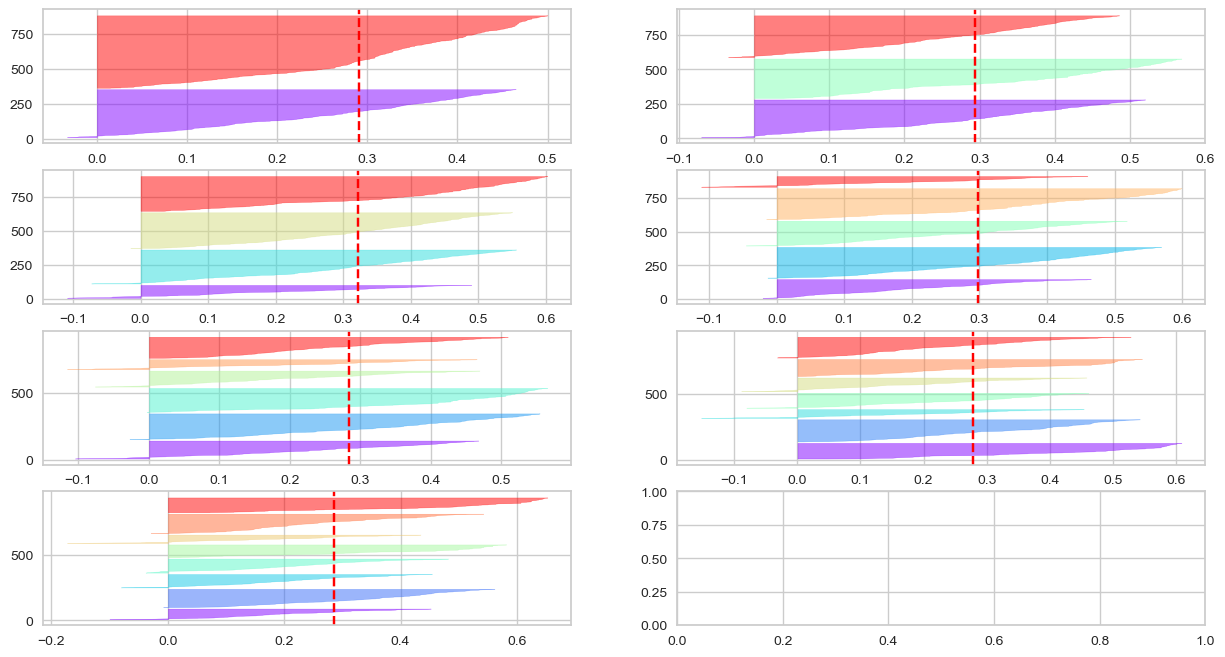

In [46]:
# data = scaled, k = 2-9, PCA-components = 3

fig, ax = plt.subplots(4, 2, figsize=(15, 8))

k_values = range(2, 9)

for i, k in enumerate(k_values):
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='rainbow', ax=ax[q, mod])
    visualizer.fit(reduced_drivers)

Difference in variation within one cluster is reducing with the number of clusters increasing. k = 3 to 5 seem to be best fits: width of cluster graphs are becoming more equal, all graphs are crossing the red delimitor, and the break out towards the left is within an acceptable range. Let's explore further.

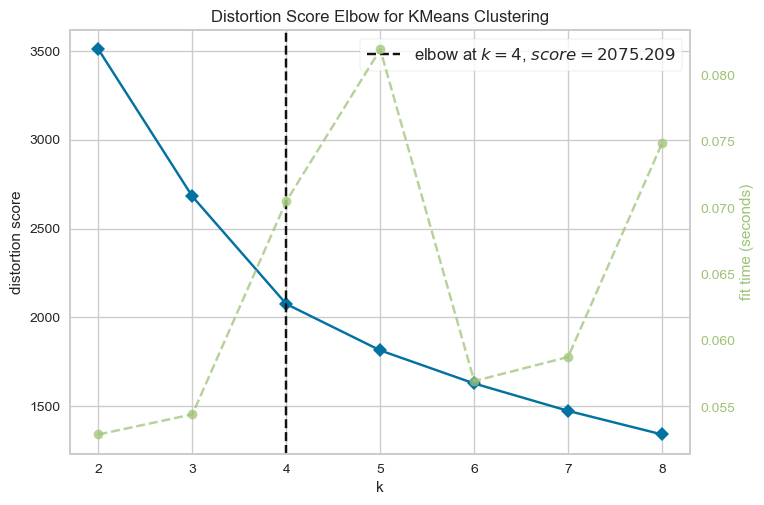

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [47]:
visualizer = KElbowVisualizer(km, k=(2,9))

visualizer.fit(reduced_drivers)
visualizer.poof()

#### For both k = 3, 4, and 5 there is a slight change in the line's direction. The strongest one at k = 4, a little elbow. Fitting time is increasing continously from k = 3 to k = 4 with k = 5 in between. I choose 4, because of the strongest elbow, relatively low fitting time, and less plots split in minus and plus for the silhouette score. 

<div style="background-color:#ADD8E6">
<h3> 6. Final Model </h3>
<p> I run KMeans with 4 clusters on the scaled dataset reduced by PCA. </p>

In [48]:
km = KMeans(n_clusters=4, random_state=42)
km.fit(reduced_drivers)
clusters = km.predict(reduced_drivers)

In [49]:
# adding the clusters, the columns defining the reference location and the drivers into a dataframe, decoding categorical columns    
new_columns = {
    'county': data_cleaned['county'], 
    'sub-county': data_cleaned['sub-county'], 
    'households_in_location': data_cleaned['households_in_location'],
    'cluster': clusters
}

for col_name, col_data in new_columns.items():
    drivers.insert(0, col_name, col_data)

for col in cat_cols:
    drivers[col] = encoders[col].inverse_transform(drivers[col])
    
drivers.head()

,cluster,households_in_location,sub-county,county,1st_reason_for_departure,2nd_reason_for_departure,3rd_reason_for_departure,1st_reason_to_drop,2nd_reason_to_drop,3rd_reason_to_drop,1st_reason_for_departure_from_origin,2nd_reason_for_departure_from_origin,3rd_reason_for_departure_from_origin,1st_reason_for_returning,2nd_reason_for_returning,1st_challenge,2nd_challenge,3rd_challenge,1st_health_concern,2nd_health_concern,3rd_health_concern,safety_concerns,educational_facility,functional_watersources,watersource_distance,water_queue_time,percent_drinkingwater_access,percent_cookingwater_access
508,3,230,Balambala,Garissa,Drought,Resource-Based Conflict,Resource-Based Conflict,Drought,Resource-Based Conflict,Banditry,Drought,Resource-Based Conflict,Resource-Based Conflict,Drought,Resource-Based Conflict,Environmental Challenges,Lack Of Food And Water,No Additional Challenge,Pneumonia,No Additional Challenge,No Additional Challenge,Weather,Yes,2,50,26,25,25
509,3,35,Balambala,Garissa,Drought,Resource-Based Conflict,Flash Floods Or Seasonal Floods,Drought,Resource-Based Conflict,Banditry,Drought,Resource-Based Conflict,Flash Floods Or Seasonal Floods,Drought,Resource-Based Conflict,Safety And Security,Ethnic Conflicts,Lack Of Food And Water,Malaria,Pneumonia,Injury,Lack Of Security,Yes,3,38,26,50,25
510,3,400,Ijara,Garissa,Drought,Resource-Based Conflict,Ethnic Clashes,Drought,Resource-Based Conflict,Resource-Based Conflict,Drought,Resource-Based Conflict,Ethnic Clashes,Drought,Wanted Or Needed To Rejoin Family,Safety And Security,No Additional Challenge,No Additional Challenge,Malaria,Pneumonia,Diarrhea,Weather,Yes,3,50,50,75,75
511,3,200,Fafi,Garissa,Drought,Resource-Based Conflict,Flash Floods Or Seasonal Floods,Drought,Resource-Based Conflict,Flash Floods Or Seasonal Floods,Drought,Resource-Based Conflict,Flash Floods Or Seasonal Floods,Drought,Resource-Based Conflict,Loss Of Livelihood,Environmental Challenges,No Additional Challenge,Malaria,Typhoid,Pneumonia,Lack Of Privacy,Yes,2,38,26,25,50
512,3,200,Fafi,Garissa,Drought,Resource-Based Conflict,Flash Floods Or Seasonal Floods,Drought,Resource-Based Conflict,Flash Floods Or Seasonal Floods,Drought,Resource-Based Conflict,Flash Floods Or Seasonal Floods,Drought,Resource-Based Conflict,Environmental Challenges,Lack Of Food And Water,Loss Of Livelihood,Tuberculosis,Pneumonia,Malaria,Lack Of Basic Services Water Electricity Etc,Yes,0,50,50,25,25


<div style="background-color:#ADD8E6">
<h3> 7. Results </h3>
<p> I want to find those features that appear to be the strongest drivers for mobility in the region. </p>

In [50]:
pca.components_

array([[ 5.80548785e-02, -7.96421196e-02, -6.69552938e-02,
         5.06847415e-02, -5.54848996e-02, -3.31734602e-03,
         2.67515548e-02, -1.07237596e-01,  7.02540337e-02,
         6.86674008e-02, -2.06327379e-02, -3.90880175e-03,
         1.98489941e-02,  5.45807793e-02, -1.31830097e-01,
         2.27773574e-02, -1.33381321e-02, -1.55465203e-01,
        -2.29126733e-03,  9.42801191e-02, -4.18125858e-01,
        -3.28668164e-01,  5.53295744e-01,  5.60657939e-01],
       [ 1.90576143e-01, -2.88742808e-01,  2.55573070e-02,
        -1.25848603e-01, -4.54779209e-01, -1.42955250e-01,
         2.32068003e-01, -3.28343737e-01, -2.58572948e-02,
         4.04915824e-01,  2.65350690e-02, -2.30390725e-01,
         3.66190377e-01, -1.33512790e-01, -1.36226517e-01,
        -1.15895767e-01, -4.48815495e-02, -1.87458173e-02,
        -1.38419704e-01, -3.61630826e-04,  2.38499440e-02,
         2.11462292e-01, -4.42753383e-02, -6.16480030e-02],
       [ 4.73605802e-01, -2.93081013e-01, -1.52311077e

If a feature has a high absolute weight in a PC, that means changes in that feature are associated with large movements along that PC. In other words, that feature contributes significantly to the variance explained by that PC. If a feature has a high absolute weight in many PCs, it can be interpreted as an important feature in the dataset.

In the first PC, the last two features have weights 0.52732475 and 0.5074439, which are the largest in absolute value. This means that these two features contribute most to the variance along the first PC.

In the second PC, the first two features have the highest absolute weights (0.34973741 and 0.33180344), so they contribute the most to the variance along the second PC.

Similarly, for the third PC, the 1st and 2nd features have the highest absolute weights (0.38281275 and 0.34526385), meaning they contribute the most to the variance along the third PC.

In [51]:
# looking at the loadings for each PC in order to determine their weight of each feature on that component
features = cat_cols + num_cols
components_df = pd.DataFrame(pca.components_, columns=features)
components_df

,1st_reason_for_departure,2nd_reason_for_departure,3rd_reason_for_departure,1st_reason_to_drop,2nd_reason_to_drop,3rd_reason_to_drop,1st_reason_for_departure_from_origin,2nd_reason_for_departure_from_origin,3rd_reason_for_departure_from_origin,1st_reason_for_returning,2nd_reason_for_returning,1st_challenge,2nd_challenge,3rd_challenge,1st_health_concern,2nd_health_concern,3rd_health_concern,safety_concerns,educational_facility,functional_watersources,watersource_distance,water_queue_time,percent_drinkingwater_access,percent_cookingwater_access
0,0.058055,-0.079642,-0.066955,0.050685,-0.055485,-0.003317,0.026752,-0.107238,0.070254,0.068667,-0.020633,-0.003909,0.019849,0.054581,-0.131830,0.022777,-0.013338,-0.155465,-0.002291,0.094280,-0.418126,-0.328668,0.553296,0.560658
1,0.190576,-0.288743,0.025557,-0.125849,-0.454779,-0.142955,0.232068,-0.328344,-0.025857,0.404916,0.026535,-0.230391,0.366190,-0.133513,-0.136227,-0.115896,-0.044882,-0.018746,-0.138420,-0.000362,0.023850,0.211462,-0.044275,-0.061648
2,0.473606,-0.293081,-0.152311,-0.249185,-0.012692,-0.015261,0.156992,-0.123913,0.000947,0.032331,-0.005819,0.392408,-0.386822,0.266834,0.165897,0.127237,-0.026095,-0.154258,-0.096996,-0.123721,-0.169390,-0.121596,-0.167921,-0.153753


In [52]:
# let's look at each PC's loadings in order of absolute value
sorted_features_pc1 = components_df.loc[0].abs().sort_values(ascending=False)
sorted_features_pc1

percent_cookingwater_access             0.560658
percent_drinkingwater_access            0.553296
watersource_distance                    0.418126
water_queue_time                        0.328668
safety_concerns                         0.155465
1st_health_concern                      0.131830
2nd_reason_for_departure_from_origin    0.107238
functional_watersources                 0.094280
2nd_reason_for_departure                0.079642
3rd_reason_for_departure_from_origin    0.070254
1st_reason_for_returning                0.068667
3rd_reason_for_departure                0.066955
1st_reason_for_departure                0.058055
2nd_reason_to_drop                      0.055485
3rd_challenge                           0.054581
1st_reason_to_drop                      0.050685
1st_reason_for_departure_from_origin    0.026752
2nd_health_concern                      0.022777
2nd_reason_for_returning                0.020633
2nd_challenge                           0.019849
3rd_health_concern  

In [53]:
sorted_features_pc2 = components_df.loc[1].abs().sort_values(ascending=False)
sorted_features_pc2

2nd_reason_to_drop                      0.454779
1st_reason_for_returning                0.404916
2nd_challenge                           0.366190
2nd_reason_for_departure_from_origin    0.328344
2nd_reason_for_departure                0.288743
1st_reason_for_departure_from_origin    0.232068
1st_challenge                           0.230391
water_queue_time                        0.211462
1st_reason_for_departure                0.190576
3rd_reason_to_drop                      0.142955
educational_facility                    0.138420
1st_health_concern                      0.136227
3rd_challenge                           0.133513
1st_reason_to_drop                      0.125849
2nd_health_concern                      0.115896
percent_cookingwater_access             0.061648
3rd_health_concern                      0.044882
percent_drinkingwater_access            0.044275
2nd_reason_for_returning                0.026535
3rd_reason_for_departure_from_origin    0.025857
3rd_reason_for_depar

In [54]:
sorted_features_pc3 = components_df.loc[2].abs().sort_values(ascending=False)
sorted_features_pc3

1st_reason_for_departure                0.473606
1st_challenge                           0.392408
2nd_challenge                           0.386822
2nd_reason_for_departure                0.293081
3rd_challenge                           0.266834
1st_reason_to_drop                      0.249185
watersource_distance                    0.169390
percent_drinkingwater_access            0.167921
1st_health_concern                      0.165897
1st_reason_for_departure_from_origin    0.156992
safety_concerns                         0.154258
percent_cookingwater_access             0.153753
3rd_reason_for_departure                0.152311
2nd_health_concern                      0.127237
2nd_reason_for_departure_from_origin    0.123913
functional_watersources                 0.123721
water_queue_time                        0.121596
educational_facility                    0.096996
1st_reason_for_returning                0.032331
3rd_health_concern                      0.026095
3rd_reason_to_drop  

#### The 10 most weighting features are:

<table>
    <tr>
        <td><b>percent_drinkingwater_access</b></td>
        <td>0.527325</td>
    </tr>
    <tr>
        <td><b>percent_cookingwater_access</b></td>
        <td>0.507444</td>
    </tr>
    <tr>
        <td><b>water_queue_time</b></td>
        <td>0.339200</td>
    </tr>
    <tr>
        <td><b>2nd_reason_for_departure</b></td>
        <td>0.368243</td>
    </tr>
    <tr>
        <td><b>2nd_reason_for_departure_from_origin</b></td>
        <td>0.350717</td>
    </tr>
    <tr>
        <td><b>1st_reason_for_returning</b></td>
        <td>0.349737</td>
    </tr>
    <tr>
        <td><b>1st_reason_for_departure</b></td>
        <td>0.339295</td>
    </tr>
    <tr>
        <td><b>3rd_challenge</b></td>
        <td>0.384282</td>
    </tr>
    <tr>
        <td><b>3rd_health_concern</b></td>
        <td>0.382813</td>
    </tr>
    <tr>
        <td><b>functional_watersources</b></td>
        <td>0.345264</td>
    </tr>
</table>

Concentrating on the features with the highest weight on their respective PC I determine, which category is the dominant one in each.

In [55]:
for col in cat_cols:
    data_cleaned[col] = encoders[col].inverse_transform(data_cleaned[col])

def value_counts_for_features(data_cleaned, features):
    for feature in features:
        print(f"Feature: {feature}")
        print(data_cleaned[feature].value_counts())
        print("--------------------")

features = ["percent_drinkingwater_access", "percent_cookingwater_access",
            "water_queue_time", "2nd_reason_for_departure",
            "2nd_reason_for_departure_from_origin", "1st_reason_for_returning",
            "1st_reason_for_departure", "3rd_challenge",
            "3rd_health_concern", "functional_watersources"]

value_counts_for_features(data_cleaned, features)

Feature: percent_drinkingwater_access
25     308
50     224
75     204
100    100
0       25
Name: percent_drinkingwater_access, dtype: int64
--------------------
Feature: percent_cookingwater_access
25     324
50     251
75     179
100     80
0       27
Name: percent_cookingwater_access, dtype: int64
--------------------
Feature: water_queue_time
50    294
10    281
26    169
38    117
Name: water_queue_time, dtype: int64
--------------------
Feature: 2nd_reason_for_departure
Resource-Based Conflict            674
Ethnic Clashes                      88
Drought                             67
Flash Floods Or Seasonal Floods     28
Fires                                4
Name: 2nd_reason_for_departure, dtype: int64
--------------------
Feature: 2nd_reason_for_departure_from_origin
Resource-Based Conflict            674
Ethnic Clashes                      96
Drought                             54
Flash Floods Or Seasonal Floods     35
Fires                                2
Name: 2nd_reason